# Build SD network

In [1]:
using Revise, Plots, ArndtLabTheme, LightGraphs, DataFrames, IntervalTrees
pyplot()
theme(:arndtlab)

includet("../modules/modules_SDs.jl")

In [2]:
a = SDmoduleInit.Initialize_SD_object("../GRCh38GenomicSuperDup_sort.tab");
b = SDmoduleInit.Initialize_pyr_object(a.int_DF);
c, ind_arr, ind_arr2 = SDmoduleInit.Initialize_SD_object("../GRCh38GenomicSuperDup_sort.tab", comp3="filter");
size(b.int_DF)

(6791, 4)

In [3]:
nex = deepcopy(b)
graph_obj = NetworkAnalysis.Initialize_SD_network(b, a.int_DF);
graph_obj.mg

"Double edges = 3703 = 0.2308315671362673 of all edges"

"Self loops = 269 = 0.040414663461538464 of all nodes (or 0.05940302896632848 without filtering singleton nodes)"

"Tandem edges = 1383 = 0.08621119561151976 of all edges and 0.30815508021390375 of all intra"

"Intra = 4488 and Inter = 11554 edges"

{6656, 16042} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [4]:
graph_obj2 = NetworkAnalysis.Initialize_SD_network(nex, c.int_DF)
graph_obj2.mg

"Double edges = 2832 = 0.19540467812047196 of all edges"

"Self loops = 254 = 0.038161057692307696 of all nodes (or 0.05940302896632848 without filtering singleton nodes)"

"Tandem edges = 1305 = 0.09004346926102257 of all edges and 0.313475858755705 of all intra"

"Intra = 4163 and Inter = 10330 edges"

{6656, 14493} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

# Find jumps number for each node

In [5]:
using SparseArrays

function modify_adj_matrix(graph)
    Ad_pr = float(deepcopy(adjacency_matrix(graph)))
    for i in vertices(graph)
        neis = neighbors(graph, i)
        for n in neis
            neis2 = neighbors(graph, n)
            mat_inds = findall(x -> x in neis, neis2)
            wei = (length(mat_inds) + 1)/length(neis)
            Ad_pr[i, n] = wei
        end
    end
    Ad_pr = sparse(Matrix(Ad_pr) ./ sum(Ad_pr, dims=2))
    return Ad_pr
end

function dye_propagation(graph; iter=50)
    Ad = modify_adj_matrix(graph)
    vec = ones(size(Ad)[2])
    vecs = reshape(Float64[], size(Ad)[2], 0)

    for i in 1:iter
        vec = transpose(Ad)*vec
        vecs = cat(vecs, vec, dims=2)
    end
    
    return vecs[:, end]
end

#dye_propagation(graph_obj2.mg);

In [6]:
using GraphPlot, MetaGraphs
using Distributions


function assign_weights_edges!(graph; comp="normal")
    cc = connected_components(graph)
    cl = map(length, cc)
    bws = betweenness_centrality(graph)
    for i in vertices(graph)
        neis = neighbors(graph, i)
        for n in neis
            sum_bws = sum(bws[neis])
            if sum_bws == 0
               sum_bws = 1 
            end
            neis2 = neighbors(graph, n)
            mat_inds = findall(x -> x in neis, neis2)   # findall(x -> (x in neis) && (x != i), neis2)
            #if length(mat_inds) > 0
            if LightGraphs.weights(graph)[i, n] == 1.0     # depends on specified weight
                if comp == "normal"
                    wei = 1.001 - (length(mat_inds) + 1)/length(neis)
                elseif comp == "normal_noise"
                    wei = 1.001 - (length(mat_inds) + 1)/length(neis) + rand(Uniform(-0.00005, 0.00005))
                elseif comp == "betweenness_weight"
                    wei = 1.001 - bws[n]/sum_bws
                elseif comp == "shuffle"
                    wei = 1.001 + rand()
                end
                set_prop!(graph, i, n, :weight, wei)
            else
                if comp == "normal"
                    wei = minimum([1.001 - (length(mat_inds) + 1)/length(neis), LightGraphs.weights(graph)[i, n]])
                elseif comp == "normal_noise"
                    wei = minimum([1.001 - (length(mat_inds) + 1)/length(neis), LightGraphs.weights(graph)[i, n]]) + rand(Uniform(-0.00005, 0.00005))
                elseif comp == "betweenness_weight"
                    wei = minimum([1.001 - bws[n]/sum_bws, LightGraphs.weights(graph)[i, n]])
                elseif comp == "shuffle"
                    wei = minimum([1.001 + rand(), LightGraphs.weights(graph)[i, n]])
                end
                set_prop!(graph, i, n, :weight, wei)
            end
        end
    end
end

assign_weights_edges! (generic function with 1 method)

In [7]:
using LightGraphs, Histograms


function custom_cmp(x::String)
   number_idx = findfirst(isdigit, x)
   str, num = SubString(x, 1, number_idx-1), SubString(x, number_idx, length(x))
   return str, parse(Int, num)
end


function graph_nosec_from_graph(graph; comp="mst_krus", comp_vis=false)
    if comp == "mst_krus"
        edg_list = kruskal_mst(graph)
        gr1 = induced_subgraph(graph, edg_list)[1]
    elseif comp == "mst_prim"
        ids, n_deg_int = [], []
        ccs = connected_components(graph)
        for cc in ccs
            cc_gr = induced_subgraph(graph, cc)[1]
            edg_list = prim_mst(cc_gr)
            gr1 = induced_subgraph(cc_gr, edg_list)[1]
            emap = vertices(gr1)
            append!(ids, map(x -> get_prop(gr1, x, :id), emap))
            append!(n_deg_int, map(x -> length(neighbors(gr1, x)), emap))
        end
        n_deg_int = n_deg_int[sortperm(ids, rev=false, by=custom_cmp)]
        ids = sort(ids, by=custom_cmp)
        return n_deg_int, ids                   # maybe problem!!! only 2 outputs
    elseif comp == "all"
        gr1 = graph
        edg_list = edges(graph)
    end
    emap = vertices(gr1)
    ids = map(x -> get_prop(gr1, x, :id), emap)
    n_deg_int = map(x -> length(neighbors(gr1, x)), emap)
    n_deg_int = n_deg_int[sortperm(ids, rev=false, by=custom_cmp)]
    ids = sort(ids, by=custom_cmp)
    if comp_vis
        n_deg = convert.(UInt64, n_deg_int);
        nd_h = Histograms.Histogram(n_deg, scale=:log);
        p = plot(nd_h, yscale=:log10, xscale=:log10, line=false, markershape=:auto)
        x = range(1, 30, length=10); y = 1.0*x.^(-3);
        p = plot!(x, y, label="a = -3")
        gui(p)
    end
    return n_deg_int, ids, edg_list
end

assign_weights_edges!(graph_obj.mg, comp="normal_noise");
assign_weights_edges!(graph_obj2.mg, comp="normal_noise");
#assign_weights_edges!(graph_obj2.mg, "shuffle");
display("done")

"done"

In [9]:
n_deg, ids_hui, edg_lis = graph_nosec_from_graph(graph_obj2.mg, comp="mst_krus")

zaz = ids_hui[sortperm(n_deg, rev=true)[1:10]]   # different ids and ndegs also possible

display("These are top jumpers:")
display(b.int_DF[findfirst.(isequal.(zaz), (b.int_DF[!, :ids],)), :])
b.int_DF[!, :jumps] = zeros(Int64, size(b.int_DF)[1])

for (i, val) in enumerate(ids_hui)
    b.int_DF[b.int_DF[!,:ids] .== val, :jumps] .= n_deg[i] 
end

"These are top jumpers:"

,chr,coor_s,coor_e,ids
,String,Int64,Int64,String
1,15,28463185,28856539,id2116
2,9,39588991,40873597,id6605
3,12,6536491,6538367,id1311
4,3,125690307,125935167,id4582
5,17,20309890,20560909,id2673
6,22,15200000,15934152,id4157
7,7,5527149,5529666,id5777
8,7,63382524,63852324,id5973
9,17,32008863,32104799,id2761


# Annotate SD network with genomic features
### (!!!) Works only when additional UCSC annotation files are uploaded. One can skip this section and use resulting annotations. All annotations are at "inputcsv" folder

In [12]:
# Read functions + H

function Read_genes_and_gaps_2_DF(filename::String)
    df = DataFrame(chr=String[], coor_s=Int64[], coor_e=Int64[])
    open(filename) do sdfile
        lines = readlines(sdfile);
        coors_str = map(x -> strip(x) |> split |> x -> x[[1,2,3]], lines)
        map(x -> push!(df ,[replace(x[1], r"chr" => "") [parse.(Int64, x[2:3])...]']), coors_str)
    end
    return df
end

function Read_repli_recomb_dnase_2_DF(filename::String)
    df = DataFrame(chr=String[], coor_s=Int64[], coor_e=Int64[], value=Float64[])
    open(filename) do sdfile
        lines = readlines(sdfile);
        coors_str = map(x -> strip(x) |> split |> x -> x[[1,2,3,4]], lines)
        map(x -> push!(df ,[replace(x[1], r"chr" => "") [parse.(Int64, x[2:3])...]' parse(Float64, x[4])]), coors_str)
    end
    return df
end

function Read_repeats_2_DF(filename::String)
    df = DataFrame(chr=String[], coor_s=Int64[], coor_e=Int64[], rep_class=String[], rep_family=String[])
    open(filename) do sdfile
        lines = readlines(sdfile);
        coors_str = map(x -> strip(x) |> split |> x -> x[[1,2,3,4,5]], lines)
        map(x -> push!(df ,[replace(x[1], r"chr" => "") [parse.(Int64, x[2:3])...]' x[4] x[5]]), coors_str)
    end
    return df
end

Read_repeats_2_DF (generic function with 1 method)

In [13]:
# DF construction functions for all types of data

function construct_DF!(df::DataFrame, segments_df::DataFrame, column::Symbol)
    # for telo/centro distance
    for line in eachrow(df)
        coors = Int[]
        chr, coor_s, coor_e = line[:chr], line[:coor_s], line[:coor_e]
        coors = vcat(segments_df[segments_df[!, :chr] .== chr, :coor_s], segments_df[segments_df[!, :chr] .== chr, :coor_e])
        vals = vcat(coor_s .- coors, coors .- coor_e)
        line[column] = minimum(vals[vals .>= 0])
    end
end
                                                                            
function construct_DF!(pyrs_obj::Main.SDmoduleInit.Interval_object, sds_obj::Main.SDmoduleInit.Interval_object, column::Symbol)
    # for intrafraction and not for Hossein
    for i in eachrow(pyrs_obj.int_DF)
        sds = collect(intersect(sds_obj.int_tree[i[:chr]], (i[:coor_s], i[:coor_e])))
        intra_frac = mean(map(x -> i[:chr] == sds_obj.int_DF[sds_obj.int_DF[!, :ids] .== x.value, :chr2][1] ? 1.0 : 0.0, sds))
        i[column] = round(intra_frac, digits=3)
    end
end

function construct_DF!(df::DataFrame, segments_obj::Main.SDmoduleInit.Interval_object, column::Symbol, border::Int=-1; gap::Int=0, comp::String="mean", comp2::String="both")
    # not for Hossein
    for line in eachrow(df)
        chr, coor_s, coor_e = line[:chr], line[:coor_s], line[:coor_e]
        if border == -1
            if column in [:genes, :cpgisl_in]
                if chr in keys(segments_obj.int_tree)
                    over = collect(intersect(segments_obj.int_tree[chr], (coor_s, coor_e)))
                    for ov in over
                        line[column] += 1 
                    end
                end
            elseif column in [:repli_in, :dnase_in, :repli_deriv, :repli_vari, :recomb_in]
                if chr in keys(segments_obj.int_tree)
                    over = collect(intersect(segments_obj.int_tree[chr], (coor_s, coor_e)))
                    over = collect(map(x -> x.value, over))
                    if length(over) > 0  
                        if comp == "mean"
                            line[column] = round(mean(over), digits=3)
                        elseif comp == "derivative"
                            line[column] = maximum(over) - minimum(over)
                        elseif comp == "variance"
                            if length(over) > 1
                                line[column] = round(std(over), digits=3)
                            end
                        end
                    end
                end
            end
        else
            if column in [:gaps, :cpgisl_bor, :ctcf, :genes_bor]
                if coor_s - gap <= coor_e + gap
                    if (comp2 == "both") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - gap - border, coor_s - gap)))
                        append!(over, collect(intersect(segments_obj.int_tree[chr], (coor_e + gap, coor_e + gap + border))))
                    elseif (comp2 == "left") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - gap - border, coor_s - gap)))
                    elseif (comp2 == "right") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_e + gap, coor_e + gap + border)))
                    elseif !(chr in keys(segments_obj.int_tree))
                        over = []
                    end
                else
                    if (comp2 == "both") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - border, coor_s)))
                        append!(over, collect(intersect(segments_obj.int_tree[chr], (coor_e, coor_e + border))))
                    elseif (comp2 == "left") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - border, coor_s)))
                    elseif (comp2 == "right") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_e, coor_e + border)))
                    elseif !(chr in keys(segments_obj.int_tree))
                        over = []
                    end
                end
                for ov in over
                    line[column] += 1 
                end
            elseif column in [:repli_bor, :repli_bor_deriv, :dnase_bor, :recomb_bor]
                if coor_s - gap <= coor_e + gap
                    if (comp2 == "both") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - gap - border, coor_s - gap)))
                        append!(over, collect(intersect(segments_obj.int_tree[chr], (coor_e + gap, coor_e + gap + border))))
                    elseif (comp2 == "left") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - gap - border, coor_s - gap)))
                    elseif (comp2 == "right") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_e + gap, coor_e + gap + border)))
                    elseif !(chr in keys(segments_obj.int_tree))
                        over = []
                    end
                else
                    if (comp2 == "both") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - border, coor_s)))
                        append!(over, collect(intersect(segments_obj.int_tree[chr], (coor_e, coor_e + border))))
                    elseif (comp2 == "left") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_s - border, coor_s)))
                    elseif (comp2 == "right") & (chr in keys(segments_obj.int_tree))
                        over = collect(intersect(segments_obj.int_tree[chr], (coor_e, coor_e + border)))
                    elseif !(chr in keys(segments_obj.int_tree))
                        over = []
                    end
                end                                        
                if (length(over) > 0) & (column == :repli_bor_deriv)
                    line[column] = round(maximum(collect(map(x -> x.value, over))), digits=3)
                elseif length(over) > 0
                    line[column] = round(mean(collect(map(x -> x.value, over))), digits=3)
                end
            end
        end
    end
end


function construct_DF!(df::DataFrame, border::Int, gap::Int)
    # no idea if it matters, but in Hosseins ipython part the same function is called construct_DF_hos!
    df[!, :used_coor_l_s], df[!, :used_coor_l_e] = zeros(Int, size(df)[1]), zeros(Int, size(df)[1])
    df[!, :used_coor_r_s], df[!, :used_coor_r_e] = zeros(Int, size(df)[1]), zeros(Int, size(df)[1])
    for line in eachrow(df)
        chr, coor_s, coor_e = line[:chr], line[:coor_s], line[:coor_e]
        if coor_s - gap <= coor_e + gap
            line[:used_coor_l_s], line[:used_coor_l_e] = coor_s - gap - border, coor_s - gap
            line[:used_coor_r_s], line[:used_coor_r_e] = coor_e + gap, coor_e + gap + border
        else
            line[:used_coor_l_s], line[:used_coor_l_e] = coor_s - border, coor_s
            line[:used_coor_r_s], line[:used_coor_r_e] = coor_e, coor_e + border
        end
    end
end                                                                                                      
                                                                                                        

construct_DF! (generic function with 5 methods)

In [14]:
step_n_0 = deepcopy(b.int_DF)
step_n_100, step_n_200, step_n_300, step_n_400 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_100, step_p_200, step_p_300, step_p_400 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_500, step_p_600, step_p_700, step_p_800 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_900, step_p_1000, step_p_1100, step_p_1200 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_1300, step_p_1400, step_p_1500, step_p_1600 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_1700, step_p_1800, step_p_1900, step_p_2000 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_2100, step_p_2200, step_p_2300, step_p_2400 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_2500, step_p_2600, step_p_2700, step_p_2800 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_2900, step_p_3000 = deepcopy(b.int_DF), deepcopy(b.int_DF);

steps = [step_n_0, step_n_100, step_n_200, step_n_300, step_n_400,
    step_p_100, step_p_200, step_p_300, step_p_400, step_p_500, step_p_600, step_p_700, step_p_800, step_p_900,
    step_p_1000, step_p_1100, step_p_1200, step_p_1300, step_p_1400, step_p_1500, step_p_1600, step_p_1700, step_p_1800, step_p_1900, 
    step_p_2000, step_p_2100, step_p_2200, step_p_2300, step_p_2400, step_p_2500, step_p_2600, step_p_2700, step_p_2800, step_p_2900, step_p_3000]

border = 50
gaps = [-1*border, -2*border, -3*border, -4*border, -5*border, 
        1*border, 2*border, 3*border, 4*border, 5*border, 6*border, 7*border, 8*border, 9*border, 10*border,
        11*border, 12*border, 13*border, 14*border, 15*border, 16*border, 17*border, 18*border, 19*border, 20*border, 
        21*border, 22*border, 23*border, 24*border, 25*border, 26*border, 27*border, 28*border, 29*border, 30*border];

In [11]:
using CSV

steps_shuff, gaps_shuff = [], []

for i in 1:10    # better larger numbers of permutations
    name = "../shuffled_SDs/df_shuff"*string(i)*".bed"   # specify the path
    two = DataFrame(CSV.File(name))
    two[!, :chr] = string.(two[!, :chr])
    append!(steps_shuff, [deepcopy(two)])
    append!(gaps_shuff, 0)
end


In [15]:
# our

genes_df = Read_genes_and_gaps_2_DF("../UCSC_features/with_sex/genes_GRCh38_noprom_wsex.bed");
genes_tree = ApeLineage.Itree_from_DF_ape_lineage(genes_df, nothing);
genes_obj = SDmoduleInit.Interval_object(genes_df, genes_tree);

gaps_df = Read_genes_and_gaps_2_DF("../UCSC_features/with_sex/hg38_assembly_all_gaps_wsex.agp");
gaps_tree = ApeLineage.Itree_from_DF_ape_lineage(gaps_df, nothing);
gaps_obj = SDmoduleInit.Interval_object(gaps_df, gaps_tree);

centro_df = Read_genes_and_gaps_2_DF("../UCSC_features/with_sex/centromeres_hg38_wsex.txt");
telo_df = Read_genes_and_gaps_2_DF("../UCSC_features/with_sex/telomeres_hg38_wsex.txt");

In [16]:
# our

cpgisl_df = Read_genes_and_gaps_2_DF("../UCSC_features/with_sex/CpG_islands_hg38_wsex.bed");
cpgisl_tree = ApeLineage.Itree_from_DF_ape_lineage(cpgisl_df, nothing);
cpgisl_obj = SDmoduleInit.Interval_object(cpgisl_df, cpgisl_tree);

repli_df = Read_repli_recomb_dnase_2_DF("../UCSC_features/with_sex/Replit_GM12878_G1b1_hg38_wsex.bed");
repli_tree = ApeLineage.Itree_from_DF_ape_lineage(repli_df, :value);
repli_obj = SDmoduleInit.Interval_object(repli_df, repli_tree);

In [17]:
# only in ours now

repli_deriv_df = Read_repli_recomb_dnase_2_DF("../UCSC_features/with_sex/Replit_deriv_4_border_hg38_wsex.bed");
repli_deriv_tree = ApeLineage.Itree_from_DF_ape_lineage(repli_deriv_df, :value);
repli_deriv_obj = SDmoduleInit.Interval_object(repli_deriv_df, repli_deriv_tree);

In [18]:
# our

ctcf_df = Read_genes_and_gaps_2_DF("../UCSC_features/with_sex/CTCF_GM78_Ht1_hg38_wsex.bed");
ctcf_tree = ApeLineage.Itree_from_DF_ape_lineage(ctcf_df, nothing);
ctcf_obj = SDmoduleInit.Interval_object(ctcf_df, ctcf_tree);

recomb_df = Read_repli_recomb_dnase_2_DF("../UCSC_features/with_sex/Recomb_rate_hg38_wsex.bed");
recomb_tree = ApeLineage.Itree_from_DF_ape_lineage(recomb_df, :value);
recomb_obj = SDmoduleInit.Interval_object(recomb_df, recomb_tree);

dnase_df = Read_repli_recomb_dnase_2_DF("../UCSC_features/with_sex/DNAse_HS_master_hg38_wsex.bed");
dnase_tree = ApeLineage.Itree_from_DF_ape_lineage(dnase_df, :value);
dnase_obj = SDmoduleInit.Interval_object(dnase_df, dnase_tree);

In [19]:
repeats_df = Read_repeats_2_DF("../UCSC_features/with_sex/Repeats_classes_hg38_wsex.bed");

In [20]:
using DataFramesGenomics

function int2chr(val::Int)
    dic = Dict()
    map(x -> dic[x] = string(x), 1:22)
    dic[23], dic[24] = "X", "Y"
    return dic[val]
end

function go_thru_repeat_overlaps!(df, repeats_df, col1::Symbol, col2::Symbol, comp::String; first2=:coor_s, last2=:coor_e)
    df[!, :chr] = chr2int.(df.chr)
    repeats_df[!, :chr] = chr2int.(repeats_df.chr)
    sort!(df, [:chr, col1, col2])
    over = eachoverlap(df, repeats_df, first1=col1, last1=col2, first2=first2, last2=last2)
    nams = ["DNA", "LINE", "LTR", "SINE", "Low_complexity", "Retroposon", "Satellite", "Simple_repeat",
                    "rRNA", "snRNA", "scRNA", "srpRNA", "tRNA", "RC"]
    nams2 = ["L1", "L2", "MIR", "Alu", "Satellite"]
    for (x, y) in over
        col_c, col_f = repeats_df[y, :rep_class], repeats_df[y, :rep_family]
        if col_c in nams
            if comp == "left"
                df[x, Symbol(col_c*"_l")] += 1
            elseif comp == "right"
                df[x, Symbol(col_c*"_r")] += 1
            end
            if col_f in nams2
                if comp == "left"
                    df[x, Symbol(col_f*"_s_l")] += 1
                elseif comp == "right"
                    df[x, Symbol(col_f*"_s_r")] += 1
                end
            end
        end
    end
    df[!, :chr] = int2chr.(df.chr)
    repeats_df[!, :chr] = int2chr.(repeats_df.chr)
end

go_thru_repeat_overlaps! (generic function with 1 method)

In [21]:
using Printf

function go_thru_thru!(df_both, border, gap_value)
    # The repeats part
    # border was 100 mostly, modify steps;
    t1 = time()
    df_both[!, :DNA_l], df_both[!, :LINE_l], df_both[!, :LTR_l], df_both[!, :SINE_l] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :Low_complexity_l], df_both[!, :Retroposon_l], df_both[!, :Satellite_l], df_both[!, :Simple_repeat_l] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :rRNA_l], df_both[!, :snRNA_l], df_both[!, :scRNA_l], df_both[!, :srpRNA_l] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :tRNA_l], df_both[!, :RC_l] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]);

    df_both[!, :DNA_r], df_both[!, :LINE_r], df_both[!, :LTR_r], df_both[!, :SINE_r] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :Low_complexity_r], df_both[!, :Retroposon_r], df_both[!, :Satellite_r], df_both[!, :Simple_repeat_r] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :rRNA_r], df_both[!, :snRNA_r], df_both[!, :scRNA_r], df_both[!, :srpRNA_r] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :tRNA_r], df_both[!, :RC_r] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]);

    df_both[!, :L1_s_l], df_both[!, :L2_s_l] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :MIR_s_l], df_both[!, :Alu_s_l], df_both[!, :Satellite_s_l] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    
    df_both[!, :L1_s_r], df_both[!, :L2_s_r] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    df_both[!, :MIR_s_r], df_both[!, :Alu_s_r], df_both[!, :Satellite_s_r] = zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1]), zeros(Int, size(df_both)[1])
    
    construct_DF!(df_both, border, gap_value)
    
    go_thru_repeat_overlaps!(df_both, repeats_df, :used_coor_r_s, :used_coor_r_e, "right");
    go_thru_repeat_overlaps!(df_both, repeats_df, :used_coor_l_s, :used_coor_l_e, "left");
    display(time() - t1)
end

go_thru_thru! (generic function with 1 method)

In [22]:
function add_all_columns!(df_in)
    df_in[!, :length] = df_in[!, :coor_e] .- df_in[!, :coor_s]
    df_in[!, :centro], df_in[!, :telo], df_in[!, :gaps] = zeros(Int, size(df_in)[1]), zeros(Int, size(df_in)[1]), zeros(Int, size(df_in)[1])
    df_in[!, :genes], df_in[!, :intra_frac] = zeros(Int, size(df_in)[1]), zeros(Float64, size(df_in)[1])
    df_in[!, :cpgisl_in], df_in[!, :cpgisl_bor], df_in[!, :ctcf] = zeros(Int, size(df_in)[1]), zeros(Int, size(df_in)[1]), zeros(Int, size(df_in)[1])

    df_in[!, :repli_in], df_in[!, :repli_bor] = zeros(Float64, size(df_in)[1]), zeros(Float64, size(df_in)[1]);
    df_in[!, :repli_bor_deriv] = zeros(Float64, size(df_in)[1])
    df_in[!, :repli_deriv], df_in[!, :repli_vari] = zeros(Float64, size(df_in)[1]), zeros(Float64, size(df_in)[1]);
    df_in[!, :recomb_in], df_in[!, :recomb_bor] = zeros(Float64, size(df_in)[1]), zeros(Float64, size(df_in)[1]);
    df_in[!, :dnase_in], df_in[!, :dnase_bor] = zeros(Float64, size(df_in)[1]), zeros(Float64, size(df_in)[1]);
end

function modify_dfs_gaps!(df_in, border, gap_val)
    # border was 100 mostly, modify steps;
    construct_DF!(df_in, gaps_obj, :gaps, border, gap=gap_val);
    construct_DF!(df_in, cpgisl_obj, :cpgisl_bor, border, gap=gap_val);
    construct_DF!(df_in, dnase_obj, :dnase_bor, border, gap=gap_val);
    construct_DF!(df_in, ctcf_obj, :ctcf, border, gap=gap_val);
    construct_DF!(df_in, recomb_obj, :recomb_bor, border, gap=gap_val);
    construct_DF!(df_in, repli_obj, :repli_bor, border, gap=gap_val);
    construct_DF!(df_in, repli_deriv_obj, :repli_bor_deriv, border, gap=gap_val);

    m_repb = round(mean(df_in[df_in[!, :repli_bor] .!= 0, :repli_bor]), digits=3)
    m_recb = round(mean(df_in[df_in[!, :recomb_bor] .!= 0, :recomb_bor]), digits=3)
    m_dnab = round(mean(df_in[df_in[!, :dnase_bor] .!= 0, :dnase_bor]), digits=3)
    
    df_in[df_in[!, :repli_bor] .== 0, :repli_bor] .= m_repb;
    df_in[df_in[!, :recomb_bor] .== 0, :recomb_bor] .= m_recb;
    df_in[df_in[!, :dnase_bor] .== 0, :dnase_bor] .= m_dnab;
end

function modify_dfs_means!(df_in, column, var)
    df_in[df_in[!, column] .== 0, column] .= var;
end

modify_dfs_means! (generic function with 1 method)

In [24]:
add_all_columns!(b.int_DF);

In [25]:
for s in steps
    add_all_columns!(s);
end

for s in steps_shuff
   add_all_columns!(s) 
end

In [26]:
using Printf

function main_modification(df_in)
    construct_DF!(df_in, telo_df, :telo);
    construct_DF!(df_in, centro_df, :centro);
    construct_DF!(df_in, genes_obj, :genes, -1);
    construct_DF!(df_in, cpgisl_obj, :cpgisl_in, -1);
    construct_DF!(df_in, dnase_obj, :dnase_in, -1);
    construct_DF!(df_in, recomb_obj, :recomb_in, -1);
    construct_DF!(df_in, repli_obj, :repli_in, -1);
    construct_DF!(df_in, repli_obj, :repli_deriv, -1; comp="derivative");
    construct_DF!(df_in, repli_obj, :repli_vari, -1; comp="variance");

    modify_dfs_gaps!(df_in, border, 0);

    m_repi = round(mean(df_in[df_in[!, :repli_in] .!= 0, :repli_in]), digits=3)
    m_repder = round(mean(df_in[df_in[!, :repli_deriv] .!= 0, :repli_deriv]), digits=3)
    m_repvar = round(mean(df_in[df_in[!, :repli_vari] .!= 0, :repli_vari]), digits=3)
    m_reci = round(mean(df_in[df_in[!, :recomb_in] .!= 0, :recomb_in]), digits=3)
    m_dnai = round(mean(df_in[df_in[!, :dnase_in] .!= 0, :dnase_in]), digits=3)

    modify_dfs_means!(df_in, :repli_in, m_repi);
    modify_dfs_means!(df_in, :repli_deriv, m_repder);
    modify_dfs_means!(df_in, :repli_vari, m_repvar);
    modify_dfs_means!(df_in, :recomb_in, m_reci);
    modify_dfs_means!(df_in, :dnase_in, m_dnai);
end
    
construct_DF!(b, a, :intra_frac);
main_modification(b.int_DF);

In [27]:
function finzalize_df_cols!(df_array, border, gaps_arr)
    t1 = time()
    for (i, s) in enumerate(df_array)
        modify_dfs_gaps!(s, border, gaps_arr[i]);
        s[!, :intra_frac] = b.int_DF[!, :intra_frac]
        main_modification(s)
    end
    display(time() - t1)
end

finzalize_df_cols!(steps, border, gaps)
display("shuffs:")
finzalize_df_cols!(steps_shuff, border, gaps_shuff)

84.923024892807

"shuffs:"

In [28]:
# Repeats (2-3 mins)

go_thru_thru!(b.int_DF, border, 0);

225.0757179260254

In [77]:
# Repeats takes 2h;

for (i, s) in enumerate(steps)
    go_thru_thru!(s, border, gaps[i]);
end

for (i, s) in enumerate(steps_shuff)
   go_thru_thru!(s, border, gaps_shuff[i])
end


259.5600121021271

163.5455539226532

170.25235104560852

252.07720184326172

206.51947808265686

196.47890996932983

241.43354415893555

206.71635103225708

210.4346740245819

227.01911306381226

228.95267295837402

213.26816606521606

219.7652599811554

240.5399968624115

217.73772501945496

182.92744898796082

174.3397397994995

175.4081199169159

170.38836097717285

167.6441490650177

193.14932417869568

204.27232193946838

167.44825983047485

171.74181413650513

214.28236413002014

209.63495707511902

232.34645414352417

193.37865495681763

178.92938995361328

193.40595412254333

188.31883215904236

163.6668779850006

153.00880813598633

153.0131049156189

174.47577095031738

150.7454240322113

160.6521909236908

152.7800099849701

164.63830304145813

153.580815076828

174.29205298423767

162.11390113830566

178.77957892417908

158.02168607711792

157.2348129749298

In [31]:
rep_obj, recomb_obj, dnase_obj, genes_obj = nothing, nothing, nothing, nothing;
gaps_obj, cpgisl_obj, ctcf_obj = nothing, nothing, nothing;
repli_deriv_obj = nothing;

In [24]:
# save results in the csv format

using CSV

CSV.write("../pathto/df_ws_jumps.csv", b.int_DF)

for (i, s) in enumerate(steps)
    q = gaps[i]
    CSV.write("../pathto/df_ws_jumps$q.csv", s)
end

for (i, s) in enumerate(steps_shuff)
    CSV.write("../pathto/df_shuff_$i.csv", s)
end

# Back to SD network

In [10]:
# This cell checks the "sharp" or "suspicious" borders

using StatsBase

function filt_shit(edgs, graph)
    ccs = connected_components(graph)
    lens = map(length, ccs)
    bcs = ccs[lens .== maximum(lens)][1]
    bcs = filter(x -> length(neighbors(graph, x)) > 1, bcs)
    edgs = filter(x -> (x.src in bcs) & (x.dst in bcs), edgs)
    return edgs
end

n_deg, ids_hui, edg_lis = graph_nosec_from_graph(graph_obj.mg, comp="mst_krus")
dif = collect(edges(difference(graph_obj.mg, graph_obj2.mg)))

dif_bc = filt_shit(dif, graph_obj.mg)
edg_lis_bc = filt_shit(edg_lis, graph_obj.mg)
edg_all_bc = filt_shit(collect(edges(graph_obj.mg)), graph_obj.mg)
match = map(x -> x in edg_lis_bc ? 1 : 0, dif_bc)
val = sum(match)/length(dif_bc)
display(val)

out_lis = [] 
for i in 1:1000
    shuff_dif = sample(edg_all_bc, length(dif_bc), replace=false)
    match = map(x -> x in edg_lis_bc ? 1 : 0, shuff_dif)
    append!(out_lis, sum(match)/length(shuff_dif))
end

display("percantage of random permutations with less sharp borders:")
display(length(out_lis[out_lis .<= val])/length(out_lis))

0.07347972972972973

"percantage of random permutations with less sharp borders:"

0.0

In [21]:
using StatsBase

function copy_model_bigcomp(N::Int64, frac::Float64)
    edg_copy::Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1} = []
    gr = MetaGraph(complete_graph(2), 1.0)
    append!(edg_copy, [Edge(1, 2)])
    for i in 1:N-2
        add_vertex!(gr)
        weis = Weights(map(x -> neighbors(gr, x) |> length, vertices(gr)))
        m_node = StatsBase.sample(vertices(gr), weis)
        for nei in neighbors(gr, m_node)
           if rand() < frac
              add_edge!(gr, nei, i+2)  
           end
        end
        add_edge!(gr, m_node, i+2)
        append!(edg_copy, [Edge(m_node, i+2)])
    end
    return gr, edg_copy
end

copy_gr, edg_copy_real = copy_model_bigcomp(1325, 0.32);  # to make the number of nodes and edges proportional to what we have in the SD giant component
copy_gr

{1325, 10814} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

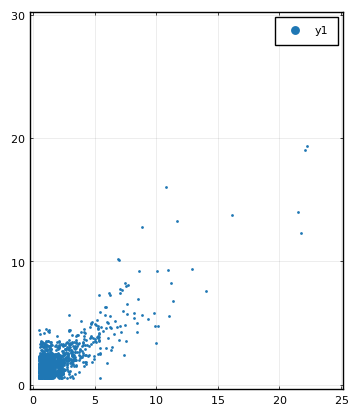

Fraction of edges match (MST Kruskal):0.6359516616314199
Fraction of edges match (Random MST):0.16767371601208458
Variance explained for MST Kruskal:0.7217923471085443
Variance explained for Random MST:0.40037048032492717
Variance explained for Simple:0.6009881501864317
Variance explained for PageRank:0.6747511671055654


In [22]:
using Statistics, StatsBase, LightGraphs


function samarkand(arr_in)
    arr_out = Int64[]
    for i in arr_in
        append!(arr_out, i.src)
        append!(arr_out, i.dst)
    end
    sort!(arr_out)
    return counts(arr_out)
end


for i in 1:nv(copy_gr)
    id = "id$i"
    set_prop!(copy_gr, i, :id, id)
end

copy_gr_copy = deepcopy(copy_gr)

assign_weights_edges!(copy_gr, comp="normal_noise")       # "shuffle", "normal_noise", betweenness_weight"
edg_copy_mst = kruskal_mst(copy_gr)  # both can be used
edg_copy_mst_prim = prim_mst(copy_gr)    # both can be used
edg_copy_mst = map(x -> x.src < x.dst ? x : Edge(x.dst, x.src), edg_copy_mst)
edg_copy_mst_prim = map(x -> x.src < x.dst ? x : Edge(x.dst, x.src), edg_copy_mst_prim)

assign_weights_edges!(copy_gr_copy, comp="shuffle")
edg_copy_mst_shuff = kruskal_mst(copy_gr_copy)
edg_copy_mst_shuff = map(x -> x.src < x.dst ? x : Edge(x.dst, x.src), edg_copy_mst_shuff)

brr = collect(map(x -> x in edg_copy_mst ? 1 : 0, edg_copy_real))
println("Fraction of edges match (MST Kruskal):", sum(brr)/length(brr))
brr = collect(map(x -> x in edg_copy_mst_shuff ? 1 : 0, edg_copy_real))
println("Fraction of edges match (Random MST):", sum(brr)/length(brr))

n_deg_mst = samarkand(edg_copy_mst)
n_deg_mst_shuff = samarkand(edg_copy_mst_shuff)
n_deg_simple = samarkand(edges(copy_gr))
n_deg_real = samarkand(edg_copy_real)
n_deg_pagerank = pagerank(copy_gr, 0.5)   # or other centralities from https://juliagraphs.org/LightGraphs.jl/v1.3/centrality/#LightGraphs.closeness_centrality
#n_deg_dye_prop = dye_propagation(copy_gr)

println("Variance explained for MST Kruskal:", cor(n_deg_real, n_deg_mst)^2);
println("Variance explained for Random MST:", cor(n_deg_real, n_deg_mst_shuff)^2);
#println("Variance explained for Dye Propagation alg:", cor(n_deg_real, n_deg_dye_prop)^2);
println("Variance explained for Simple:", cor(n_deg_real, n_deg_simple)^2);
println("Variance explained for PageRank:", cor(n_deg_real, n_deg_pagerank)^2);

n_deg_mst = n_deg_mst .+ rand(length(n_deg_mst)) .- 0.5
n_deg_real = n_deg_real .+ rand(length(n_deg_real)) .- 0.5

p = plot(n_deg_real, n_deg_mst, line=false, markershape=:auto, markersize=2.0, aspect_ratio=:equal);
gui(p)